** Imports ** 

In [9]:
import sys
import scipy.io as sio
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
sys.path.append('../code/functions')
import qaLib as qLib
sys.path.append('../../pipeline_1/code/functions')
import connectLib as cLib
from IPython.display import Image
import random
from connectLib import otsuVox

# Algorithm 

## Pseudocode 

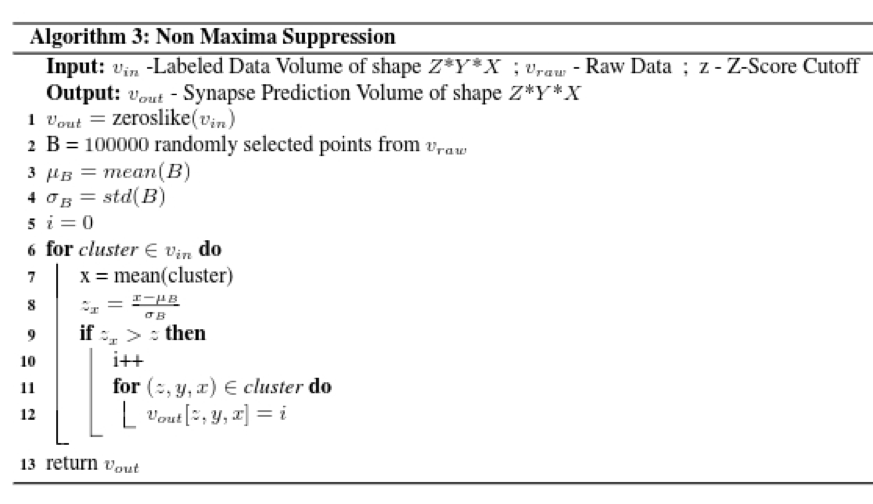

In [3]:
Image(filename = "images/nonMaxima.png")

## Actual Code

In [134]:
def nonMaximaSupression(clusterList, image, z):
    randClusterDist = []
    for i in range(100000):
        point = [int(random.random()*image.shape[0]), int(random.random()*image.shape[1]), int(random.random()*image.shape[2])]
        randClusterDist.append(image[point[0]][point[1]][point[2]])

    mu = np.average(randClusterDist)
    sigma = np.std(randClusterDist)
    
    aveList = []
    for cluster in clusterList:
        curClusterDist = []
        for member in cluster.members:
            curClusterDist.append(image[member[0]][member[1]][member[2]])
        aveList.append(np.mean(curClusterDist))
    
    finalClusters = []
    for i in range(len(aveList)): #this is bad and i should feel bad
        if (aveList[i] - mu)/float(sigma) > z:
            finalClusters.append(clusterList[i])
            
    return finalClusters

## Algorithm Conditions 

We believe nonMaxSupression will perform well if and only if the histogram of the data is capable of producing z-scores - i.e. there is variance in the brightness.

## Data on which nonMaxSupression will perform well and poorly 

The data set on which nonMaxSupression will perform well is a gradient image. We are trying to extract anything with a z-score above 7, and this should clearly extract that. 

The data set on which nonMaxSupression will perform poorly is a linear image. It will perform poorly because the data does not follow a normal curve.

## Raw Data Plot

### Good Data

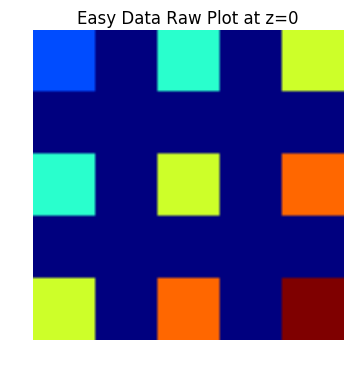

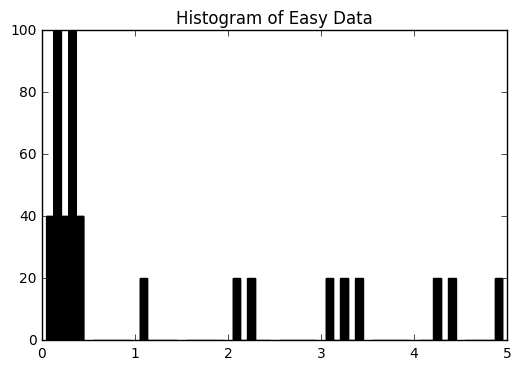

In [108]:
simEasyGrid = np.zeros((100, 100, 100))
for i in range(4):
    for j in range(4):
        for k in range(4):
            simEasyGrid[20*(2*j): 20*(2*j + 1), 20*(2*i): 20*(2*i + 1), 20*(2*k): 20*(2*k + 1)] = i + j + k + 1
            
            
plt.imshow(simEasyGrid[5])
plt.axis('off')
plt.title('Easy Data Raw Plot at z=0')
plt.show()
plt.hist(simEasyGrid[0])
plt.title("Histogram of Easy Data")
plt.show()

## Prediction on Good Data 
I predict that nonMaxSupression will pick up the higher range of clusters.

### Challenging Data

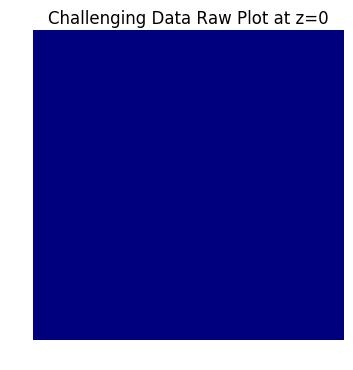

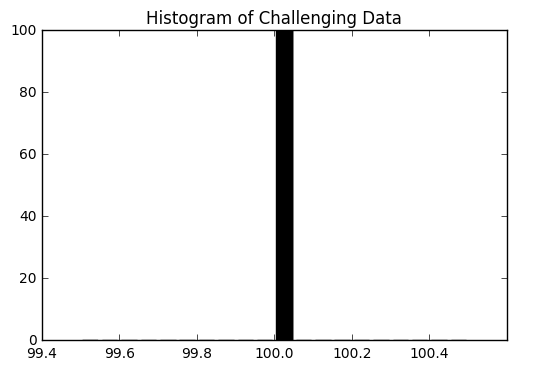

In [80]:
simDiff = np.zeros((100, 100, 100))

for i in range(100):
    for j in range(100):
        for k in range(100):
            simDiff[i][j][k] = 100
            
            
plt.imshow(simDiff[5])
plt.axis('off')
plt.title('Challenging Data Raw Plot at z=0')
plt.show()
plt.hist(simDiff[0], bins=20)
plt.title("Histogram of Challenging Data")
plt.show()

## Prediction on Challenging Data 
I predict that nonMaxSupression will will not be able to calculate z scores, and thus will fail.

# Simulation
## Generate Toy Simulation Data
### Easy Data
I believe this data will look la grid of different-colored squares.

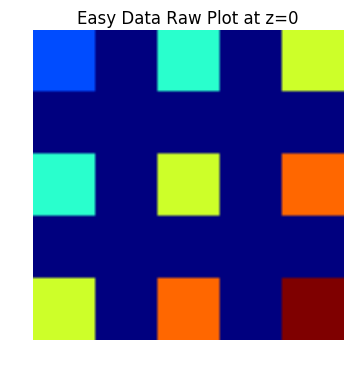

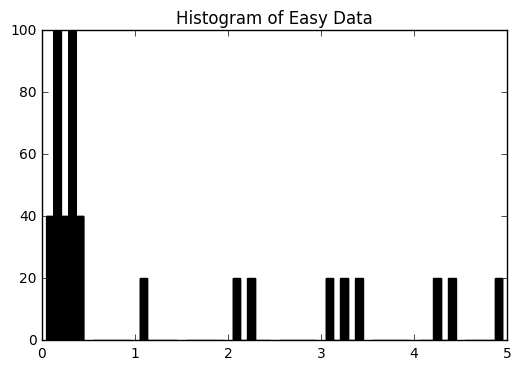

In [113]:
simEasyGrid = np.zeros((100, 100, 100))
for i in range(4):
    for j in range(4):
        for k in range(4):
            simEasyGrid[20*(2*j): 20*(2*j + 1), 20*(2*i): 20*(2*i + 1), 20*(2*k): 20*(2*k + 1)] = i + j + k + 1
            
            
plt.imshow(simEasyGrid[5])
plt.axis('off')
plt.title('Easy Data Raw Plot at z=0')
plt.show()
plt.hist(simEasyGrid[0])
plt.title("Histogram of Easy Data")
plt.show()

The easy data looks exactly as I expected. The histogram is has deviation, meaning nonMaxSupression will be able to extract maxima.

## Difficult Data 
I expect that the difficult data will look like a constant image.

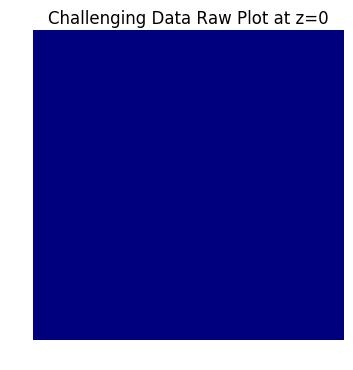

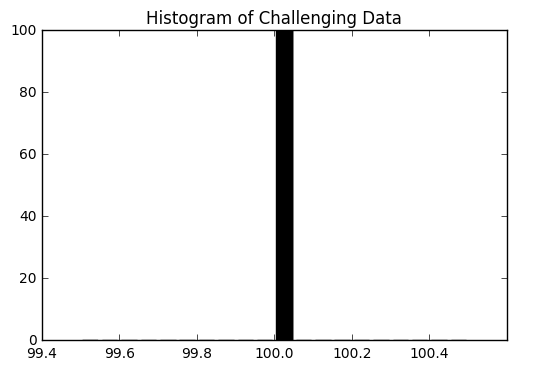

In [82]:
simDiff = np.zeros((100, 100, 100))

for i in range(100):
    for j in range(100):
        for k in range(100):
            simDiff[i][j][k] = 100
            
            
plt.imshow(simDiff[5])
plt.axis('off')
plt.title('Challenging Data Raw Plot at z=0')
plt.show()
plt.hist(simDiff[0], bins=20)
plt.title("Histogram of Challenging Data")
plt.show()

The difficult data looks exactly as I expected. The histogram is a single value, which is the kind of data nonMaxSupression fails on.

## Toy Data Analysis

For the good data, I predict that otsuVox will select the voxels in the rightmost normal curve.
For the bad data, I predict that otsuVox will randomly select one normal curve. 

In [135]:
otsuOutEasy = otsuVox(simEasyGrid)
otsuClustersEasy = cLib.clusterThresh(otsuOutEasy, 0, 1000000)
nonMaxClusters = nonMaximaSupression(otsuClustersEasy, simEasyGrid, 1)
nonMaxEasy = np.zeros_like(simEasy)
for cluster in nonMaxClusters:
    for member in cluster.members:
        nonMaxEasy[member[0]][member[1]][member[2]] = 1

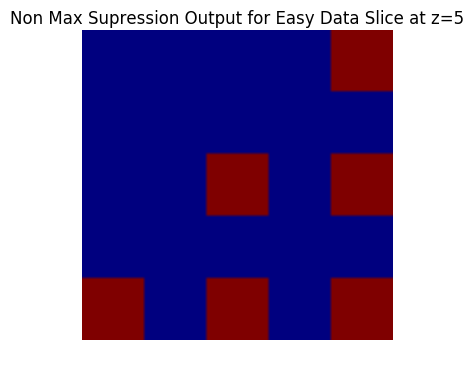

In [136]:
plt.imshow(nonMaxEasy[5])
plt.axis('off')
plt.title('Non Max Supression Output for Easy Data Slice at z=5')
plt.show()

As expected, otsuVox picked up just the brightest clusters.

In [137]:
otsuOutDiff = otsuVox(simDiff)
otsuClustersDiff = cLib.clusterThresh(otsuOutDiff, 0, 1000000)
nonMaxClusters = nonMaximaSupression(otsuClustersDiff, simDiff, 0)
nonMaxDiff = np.zeros_like(simDiff)
for cluster in nonMaxClusters:
    for member in cluster.members:
        nonMaxDiff[member[0]][member[1]][member[2]] = 1

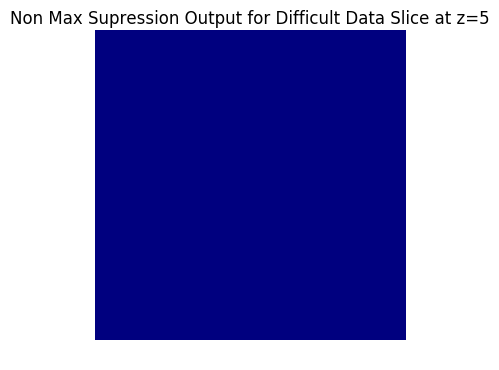

In [138]:
plt.imshow(nonMaxDiff[5])
plt.axis('off')
plt.title('Non Max Supression Output for Difficult Data Slice at z=5')
plt.show()

As expected, otsuVox failed to pick out bright things because there was no deviation in the image.

# Real Data

In [7]:
procData = []
for mat in glob.glob('../../data/matlabData/collman15v2/*_p1.mat'):
    name = mat[34:-7]
    rawData = sio.loadmat(mat)
    npData = np.rollaxis(rawData[name], 2, 0)
    procData.append([name, npData])

In [13]:
realData = procData[12][1]

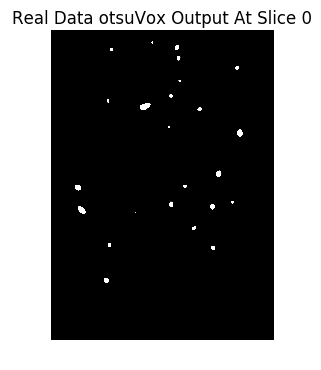

In [14]:
otsuOutReal = otsuVox(realData)
plt.imshow(otsuOutReal[0], cmap='gray')
plt.title('Real Data otsuVox Output At Slice 0')
plt.axis('off')
plt.show()

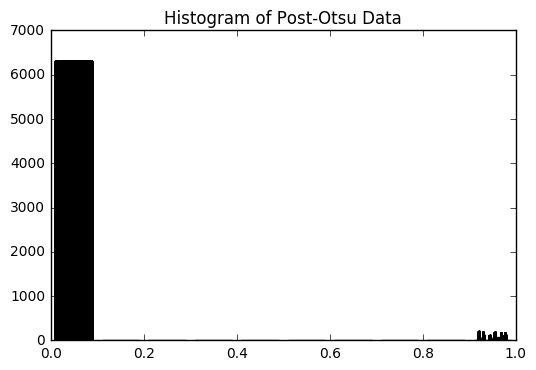

In [16]:
plt.hist(otsuOutReal[0])
plt.title("Histogram of Post-Otsu Data")
plt.show()

As we can see, the real data has a mean and a standard deviation. This means that nonMaximaSupression should be able to extract the bright spots.

In [16]:
otsuClusters = cLib.clusterThresh(otsuOutReal, 0, 10000000)

In [76]:
nonMaxClusters = nonMaximaSupression(otsuClusters, realData, 6)

In [78]:
nonMaxImg = np.zeros_like(realData)
for cluster in nonMaxClusters:
    for member in cluster.members:
        nonMaxImg[member[0]][member[1]][member[2]] = 1

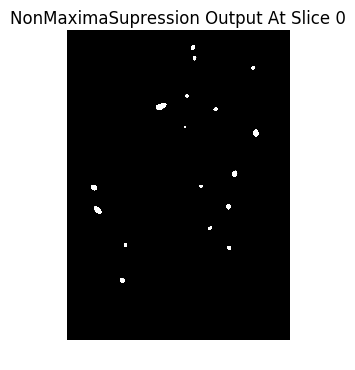

In [79]:
plt.imshow(nonMaxImg[0], cmap='gray')
plt.title('NonMaximaSupression Output At Slice 0')
plt.axis('off')
plt.show()

## Precision/Recall/F1 before nonMaximaSupression

In [40]:
labelClusters = cLib.clusterThresh(procData[0][1], 0, 10000000)

In [9]:
otsuClusters = cLib.clusterThresh(otsuOutReal, 0, 10000000)

In [14]:
precision, recall, F1 = qLib.precision_recall_f1(labelClusters, otsuClusters)

In [15]:
print 'Precision: ' + str(precision)
print 'Recall: ' + str(recall)
print 'F1: ' + str(F1)

Precision: 0.61875
Recall: 0.697478991597
F1: 0.655759945732


## Precision/Recall/F1 after nonMaximaSupression

In [71]:
precision, recall, F1 = qLib.precision_recall_f1(labelClusters, nonMaxClusters)

In [72]:
print 'Precision: ' + str(precision)
print 'Recall: ' + str(recall)
print 'F1: ' + str(F1)

Precision: 0.855769230769
Recall: 0.621848739496
F1: 0.720293104391
